In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ray
import pandas as pd
import seaborn as sns

In [3]:
_ = ray.init(num_cpus=12)

2020-12-02 17:09:21,507	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8266


In [4]:
from robust_gcn_structure import loader
from abs.gcn_abs import certify

import time
import warnings
warnings.filterwarnings('ignore')

In [5]:
@ray.remote
def check(dataset, node_range, Q, q, solver="ECOS"):
    warnings.filterwarnings('ignore')
    times = []
    A, X, z = loader.load_dataset(dataset)
    weight_list = loader.load_network(dataset, False)

    cert_count = 0
    uncert_count = 0
    not_sure = 0
    for i in node_range:
        start = time.time()
        lb, ub = certify(i, A, X, weight_list, z, q, Q, dataset)
        if lb > 0:
            cert_count += 1
        elif ub < 0:
            uncert_count += 1
        else:
            not_sure += 1
        end = time.time()
        
        times.append(end-start)

    return (cert_count, uncert_count, not_sure), times

In [6]:
budgets = [(1, 1), (5, 3), (10, 5)]
datasets = ["citeseer", "cora_ml", "pubmed"]
node_range = range(0, 1000)

In [7]:
res = []
for d in datasets:
    for b in budgets:
        res.append(check.remote(d, node_range, *b))

In [8]:
i = 0
cert_data = {"dataset": [], "budgets": [], "cert": [], "uncert": [], "not_sure": []}
time_data = {"node": [], "dataset": [], "budgets": [], "solving_time": []}

for d in datasets:
    for b in budgets:        
        (cert, uncert, not_sure), times = ray.get(res[i])
        cert_data["dataset"].append(d)
        cert_data["budgets"].append(str(b))
        cert_data["cert"].append(cert)
        cert_data["uncert"].append(uncert)
        cert_data["not_sure"].append(not_sure)
        
        for n, t in zip(node_range, times):
            time_data["node"].append(n)
            time_data["dataset"].append(d)
            time_data["budgets"].append(str(b))
            time_data["solving_time"].append(t)
        
        i = i+1

In [9]:
cert_df = pd.DataFrame.from_dict(cert_data)
cert_df

,dataset,budgets,cert,uncert,not_sure
0,citeseer,"(1, 1)",712,16,272
1,citeseer,"(5, 3)",676,12,312
2,citeseer,"(10, 5)",472,5,523
3,cora_ml,"(1, 1)",843,0,157
4,cora_ml,"(5, 3)",769,0,231
5,cora_ml,"(10, 5)",704,0,296
6,pubmed,"(1, 1)",855,15,130
7,pubmed,"(5, 3)",646,3,351
8,pubmed,"(10, 5)",612,4,384


In [14]:
cert_df["cert"] /= 1000
cert_df["uncert"] /= 1000
cert_df["not_sure"] /= 1000

In [15]:
cert_df

,dataset,budgets,cert,uncert,not_sure
0,citeseer,"(1, 1)",0.712,0.016,0.272
1,citeseer,"(5, 3)",0.676,0.012,0.312
2,citeseer,"(10, 5)",0.472,0.005,0.523
3,cora_ml,"(1, 1)",0.843,0.000,0.157
4,cora_ml,"(5, 3)",0.769,0.000,0.231
5,cora_ml,"(10, 5)",0.704,0.000,0.296
6,pubmed,"(1, 1)",0.855,0.015,0.130
7,pubmed,"(5, 3)",0.646,0.003,0.351
8,pubmed,"(10, 5)",0.612,0.004,0.384


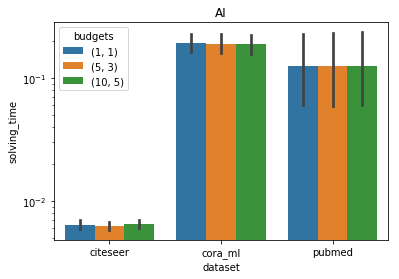

In [17]:
time_df = pd.DataFrame.from_dict(time_data)
g = sns.barplot(data=time_df, x="dataset", y="solving_time", hue="budgets")
g.set(title="AI")
g.set_yscale("log")

In [11]:
cert_df.to_csv("res/ai_cert.csv")
time_df.to_csv("res/ai_time.csv")